# Lab III
## Classification & Model Evaluation

In [0]:
# Some IPython magic
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Introduction

In this lab, we will try out some classification algorithms and discover ways to evaluate them properly. Check out the course for details on how each algorithm works, and when you should use them.

Check out these additional materials for each algorithm:

- [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

- [Decision Trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

- [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In sklearn, there are implementations of each of these. We won't do any bare numpy implementations this time.

Recall some of the cheet-sheets we mentioned previously:

- [numpy](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
- [pandas](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf)
- [sklearn](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf)





## Detour -  One-Hot Encoding

In many real-life scenarios, we may encounter cases in which a feature is ***categorical***. 

For instance a *sex* attribute for a animal could take values from the set $\{M, F, I\}$ , that is : *male*, *female* and *infant*.

In [2]:
dataframe = pd.DataFrame(data={'sex': ['M', 'M', 'F', 'I', 'F', 'F', 'I']})
print(dataframe)

  sex
0   M
1   M
2   F
3   I
4   F
5   F
6   I


How should we deal with this? A possible solution is to assign an integer to each value, like so:



In [3]:
dataframe['categorical_sex'] = pd.factorize(dataframe['sex'])[0]
dataframe

,sex,categorical_sex
0,M,0
1,M,0
2,F,1
3,I,2
4,F,1
5,F,1
6,I,2


The problem with this approach is that it imples an *order* to the values, which could mess up our learning. Why should ***F (encoded as 1)*** be greater than **M (encoded as 0)**? 

A better approach is to use ***one-hot encoding***, which creates additional features, based on the categories. In this case we would have 3 additional features that answer the question: **Is the sex M / F / I?**

In [4]:
one_hot_encoded_sex = pd.get_dummies(dataframe['sex'], prefix='is_sex')
one_hot_encoded_sex

,is_sex_F,is_sex_I,is_sex_M
0,0,0,1
1,0,0,1
2,1,0,0
3,0,1,0
4,1,0,0
5,1,0,0
6,0,1,0


This way, even though we increase the **dimensionality** of our data, we have a better representation of it. In some cases (where the feature matrix needs to be invertible) you can throw one of the columns. For a binary feature, it is suficient to ask one question (e.g. is the sex male?). Similarly, for N classes you can ask N-1 questions.

## Decision Boundary 

For a classification algorithm, the decision boundary is a separating surface between the two (or more) classes. For logistic regression, two classes, we interpret the output as a probability of a point belonging to a class. Therefore, in order to get the decision boundary of a logistic model we need to solve the equation: 

\begin{gather}
p(x) = \frac{1}{1 + \exp(- (\sum_j W_j x_j + b) )} = \frac12
\\ 1 + \exp(- (\sum_j W_j x_j + b) ) = 2
\\ \exp(- (\sum_j W_j x_j + b) ) = 1
\\ - (\sum_j W_j x_j + b) = 0
\\ \sum_j W_j x_j + b = 0
,\end{gather}

Another way to do it is to define a grid and plot the probability**  $P(y = 1)$ **in each grid cell

In [0]:
def plot_decision_boundary(model, X, y):
  """
    Use this to plot the decision boundary of a trained model.
  """
  
  xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
  f, ax = plt.subplots(figsize=(8, 6))
  contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                        vmin=0, vmax=1)
  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])

  ax.scatter(X[:,0], X[:, 1], c=y, s=50,
             cmap="RdBu", vmin=-.2, vmax=1.2,
             edgecolor="white", linewidth=1)

  ax.set(aspect="equal",
         xlim=(-5, 5), ylim=(-5, 5),
         xlabel="$X_1$", ylabel="$X_2$")

## Toy Dataset - Binary Classification

Use the data below to train each model, and plot the decision boundary for each of them.

In [0]:
from sklearn import datasets
X, y = datasets.make_classification(n_samples=2000, 
                           n_features=2, 
                           n_informative=2,
                           n_classes=2, 
                           n_clusters_per_class=1,
                           n_redundant=0,
                           class_sep=0.75,
                           random_state=15)

### Cross Validation



LogisticRegression 0.948
DecisionTreeClassifier 0.942
RandomForestClassifier 0.956


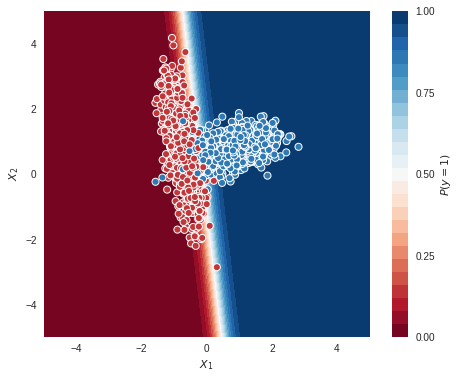

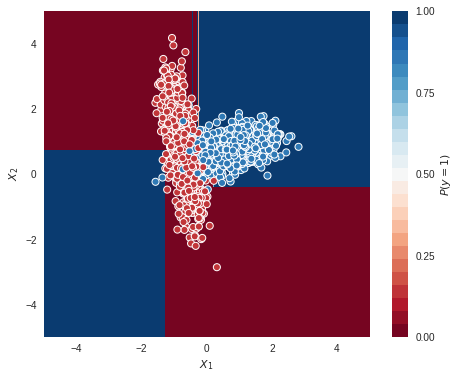

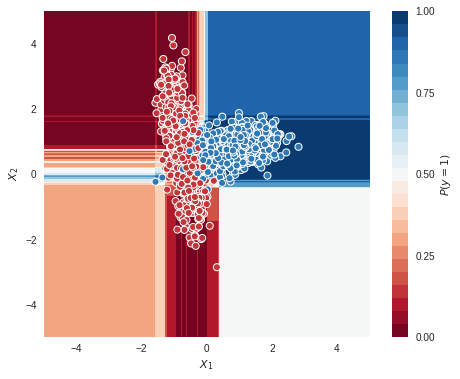

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# TODO 1: Use sklearn.model_selection.train_test_split to split your data

x_train, x_test, y_train, y_test = train_test_split(X, y)


for i, Model in enumerate([LogisticRegression, DecisionTreeClassifier, RandomForestClassifier]):
  model = Model()

  # TODO 2: Train each of the models on the training data
  
  model.fit(x_train, y_train)
  
  # TODO 3: Plot the decision boundary of each model. Use plot_decision_boundary() from above. 
  
  plot_decision_boundary(model, X, y)
  
  accuracy = accuracy_score(model.predict(x_test), y_test)
  print(Model.__name__, accuracy)
  
# TODO 4: Calculate accuracy on the test set

### K-Fold Cross Validation

Firstly, we will split the data into 2: a training set and a test set. We will use the training set to apply K-Fold cross validation.

Use the test set to evaluate the model only **after** you tune your hyper-parameters! 

In [16]:
from sklearn.model_selection import KFold


# TODO 1: Split your data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y)


# TODO 2: Use KFold to further split your training data into train and validation

kf = KFold(n_splits=4)

# TODO 3: Train your models on the training data for each fold, and validate on the validation set. 

# Tune parameters here.

for i, (Model, kwargs) in enumerate([(LogisticRegression, {}), (DecisionTreeClassifier, {}), (RandomForestClassifier, {})]):

  accuracies = []
  
  for k, (train_index, test_index) in enumerate(kf.split(x_train)):

    xx_train = x_train[train_index]
    yy_train = y_train[train_index]

    xx_validation = x_train[test_index]
    yy_validation = y_train[test_index]
  
    model = Model(**kwargs)
    model.fit(xx_train, yy_train)
    
    validation_accuracy = accuracy_score(model.predict(xx_validation), yy_validation)
    accuracies.append(validation_accuracy)
    
    print(Model.__name__, "split", k, "validation accuracy", validation_accuracy)
  print("Average validation accuracy:", np.average(accuracies))
    
  print()


LogisticRegression split 0 validation accuracy 0.9573333333333334
LogisticRegression split 1 validation accuracy 0.9493333333333334
LogisticRegression split 2 validation accuracy 0.952
LogisticRegression split 3 validation accuracy 0.9626666666666667
Average validation accuracy: 0.9553333333333334

DecisionTreeClassifier split 0 validation accuracy 0.9306666666666666
DecisionTreeClassifier split 1 validation accuracy 0.9466666666666667
DecisionTreeClassifier split 2 validation accuracy 0.9493333333333334
DecisionTreeClassifier split 3 validation accuracy 0.9493333333333334
Average validation accuracy: 0.944

RandomForestClassifier split 0 validation accuracy 0.952
RandomForestClassifier split 1 validation accuracy 0.952
RandomForestClassifier split 2 validation accuracy 0.944
RandomForestClassifier split 3 validation accuracy 0.9466666666666667
Average validation accuracy: 0.9486666666666667



In [17]:
# Using the found parameters, train on everything and test on the test set.
for i, (Model, kwargs) in enumerate([(LogisticRegression, {}), (DecisionTreeClassifier, {}), (RandomForestClassifier, {})]):
  model = Model(**kwargs)
  model.fit(x_train, y_train)
  
  test_accuracy = accuracy_score(model.predict(x_test), y_test)
  
  print(Model.__name__, "test accuracy", test_accuracy)

LogisticRegression test accuracy 0.938
DecisionTreeClassifier test accuracy 0.938
RandomForestClassifier test accuracy 0.952


## (Almost) Real-World Scenario - Iris Dataset

In [0]:
import sklearn.datasets as datasets


iris = datasets.load_iris()

X = iris.data
y = iris.target

In [31]:
from sklearn.metrics import classification_report


x_train, x_test, y_train, y_test = train_test_split(X, y)

# Tune parameters / do some visualisations

logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic.fit(x_train, y_train)
print("LogisticRegression")
print(classification_report(y_test, logistic.predict(x_test)))


tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
print("DecisionTree")
print(classification_report(y_test, tree.predict(x_test)))

forest = RandomForestClassifier()
forest.fit(x_train, y_train)
print("RandomForest")
print(classification_report(y_test, forest.predict(x_test)))



LogisticRegression
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      0.86      0.92        14
          2       0.86      1.00      0.92        12

avg / total       0.95      0.95      0.95        38

DecisionTree
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       0.90      0.64      0.75        14
          2       0.69      0.92      0.79        12

avg / total       0.86      0.84      0.84        38

RandomForest
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       0.92      0.86      0.89        14
          2       0.85      0.92      0.88        12

avg / total       0.92      0.92      0.92        38



## Visualize DecisionTree

Before running this cell, make sure to install the required packages **in your environment**:

```
conda install -c anaconda graphviz
```
Or run the following cell:

In [22]:
# If you get some error, you can skip this part.
!pip install graphviz
!apt install graphviz


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,154 kB o

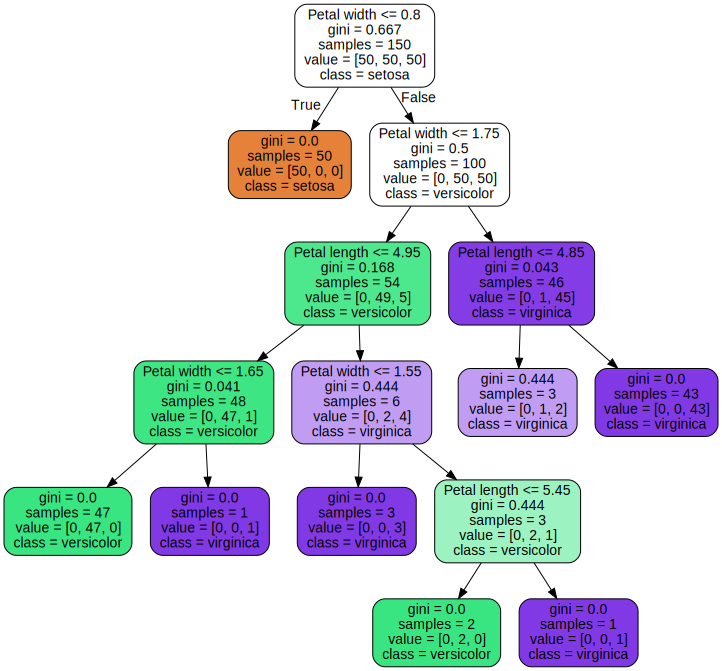

In [23]:
import graphviz
from sklearn.tree import export_graphviz

# TODO 1: Train a DecisionTreeClassifier on the iris dataset.


iris_feature_names = np.array(['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
features_pair = [2, 3] # we will use only two features, because it's easier to visualize

iris_data_features = iris_feature_names[features_pair]
X = iris.data[:, features_pair] # load the examples
y = iris.target # load the target classes
y_ = np.array([iris.target_names[class_] for class_ in y]) # give each class a name

model = DecisionTreeClassifier()
model.fit(X, y)

dot_data = export_graphviz(model,
                           out_file=None,
                           feature_names=iris_data_features,
                           class_names=iris.target_names,
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph

## Imbalanced Learning


Recall the evaluation metrics from the course:

$Precision=\frac{TP}{TP + FP}$


$Recall=\frac{TP}{TP + FN}$


$F_1=\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$

We will use them to properly evaluate imbalanced datasets.

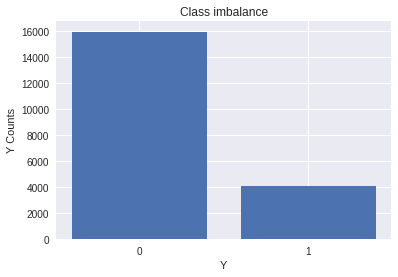

In [83]:

# This is an imbalanced dataset. Be wary of accuracy!

X, y = datasets.make_classification(n_samples=20000, 
                           n_features=2, 
                           n_informative=2,
                           n_classes=2, 
                           n_clusters_per_class=1,
                           n_redundant=0,
                           weights=[0.70, 0.10],
                           class_sep=0.0,
                           random_state=2)

plt.bar(np.arange(2), np.unique(y, return_counts=True)[1])
plt.xticks(np.arange(2), ('0', '1'))
plt.xlabel('Y')
plt.ylabel('Y Counts')
plt.title('Class imbalance')
plt.show()


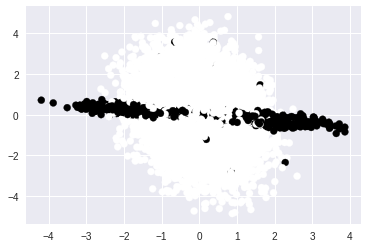

In [84]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Important Metrics: Accuracy, Precision and Recall

In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# TODO 1: Train some model of your choosing, and apply each of the metrics on the test set. 

x_train, x_test, y_train, y_test = train_test_split(X, y)

logistic = LogisticRegression()
logistic.fit(x_train, y_train)

print(accuracy_score(y_test, logistic.predict(x_test)))
print("Precision:", precision_score(y_test, logistic.predict(x_test)))
print("Recall:", recall_score(y_test, logistic.predict(x_test)))


print(confusion_matrix(y_test, logistic.predict(x_test)))


# Compare that to plain accuracy.

0.8018
Precision: 0.0
Recall: 0.0
[[4009    0]
 [ 991    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Over-Sampling and Down-Sampling

To deal with imbalanced datasets, one strategy is to over-sample the minority class, or to downsample the majority class. For now, we will use 

[**Synthetic minority over-sampling technique**](https://arxiv.org/pdf/1106.1813.pdf)

Make sure to install [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/api.html) python package:

```
conda install -c conda-forge imbalanced-learn 
```

Check out this article on how to properly apply SMOTE:

[The Right Way to Oversample in Predictive Modeling](https://beckernick.github.io/oversampling-modeling/)

The gist of it is that you should first split your data into train and test and **then** apply SMOTE. Otherwise, if you first over-sample and then split, some of the oversampled data will be present in the test set and then the evaluation will be incorrect!

In [74]:
!pip install imbalanced-learn

    100% |████████████████████████████████| 174kB 6.8MB/s 
    100% |████████████████████████████████| 5.3MB 4.9MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [80]:
import imblearn.over_sampling as over_sampling

smote = over_sampling.SMOTE(ratio=1.0)

# TODO 1: Split your data into train and test (using train_test_split).

x_train, x_test, y_train, y_test = train_test_split(X, y)

# TODO 2: Use SMOTE to oversample the *training data*.

x_train_res, y_train_res = smote.fit_sample(x_train, y_train)


# TODO 3: Train a model on the oversampled data.

logistic = LogisticRegression()
logistic.fit(x_train_res, y_train_res)

# TODO 4: Evaluate the model on the test set with the proper metrics.

print("Precision:", precision_score(y_test, logistic.predict(x_test)))
print("Recall:", recall_score(y_test, logistic.predict(x_test)))



Precision: 0.19623655913978494
Recall: 0.4941972920696325


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The **imbalanced-learn** package also contains methods for under-sampling. Test them out on our data!

In [0]:
import imblearn.under_sampling as under_sampling

# TODO 1: Test out some under-sampling techniques.